In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
from decimal import *

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import allantools
import scipy 

sys.path.append('../../qerr')
sys.path.append('qerr')
sys.path.append('quabo/pano_software')
sys.path.append('quabo/pano_software/util')

from dgnss_utils import panoseti_file_interfaces as pfi
from dgnss_utils import pff
from qerr_utils import *

In [2]:
def load_ph_data(data_dir, run_dir, module_id):
    """
    Create a pd.DataFrame containing the header information of every PH event in data_dir/run_dir for module_id.
    """
    ori = pfi.ObservingRunInterface(data_dir, run_dir)
    if module_id not in ori.obs_pff_files:
        print(f'No module with ID "{module_id}"\n'
              f'Available module_ids:\n\t{list(ori.obs_pff_files.keys())}')
        return
    columns = [
        'wr_timestamp (s)',
        'quabo_num',
        'pkt_num',
        'pkt_tai',
        'pkt_nsec',
        'tv_sec',
        'tv_usec',
        # 'img_data'
    ]
    ph_df = pd.DataFrame(columns=columns)
    
    for ph_file in ori.obs_pff_files[module_id]["ph"]:
        fname = ph_file["fname"]
        fpath = f'{data_dir}/{run_dir}/{fname}'
        with open(fpath, 'rb') as fp:
            frame_iterator = ori.pulse_height_frame_iterator(fp, 1)
            for j, img in frame_iterator:
                j['wr_timestamp (s)'] = pff.wr_to_unix_decimal(j['pkt_tai'], j['pkt_nsec'], j['tv_sec'])
                # j['img_data'] = img
                ph_df.loc[len(ph_df)] = j
    ph_df['unix_timestamp'] = pd.to_datetime(ph_df['wr_timestamp (s)'].astype(np.float64), unit = 's', utc=True)
    ph_df = ph_df.sort_values(by='wr_timestamp (s)')
    return ph_df


def load_qerr_df(fpath):
    """
    Load the pd.DataFrame containing quantization error (qerr) data produced by qerr/capture_qerr.py
    """
    df = load_data(fpath)
    df['unix_timestamp'] = pd.to_datetime(df['pkt_unix_timestamp_TIM-TP'], unit='ns')
    # qerr data timestamps are in pacific time
    df['unix_timestamp'] = df['unix_timestamp'].dt.tz_localize('US/Pacific').dt.tz_convert('utc')
    df['qErr (ns)'] = df['qErr (ps)'] * 1e-3
    df = df.sort_values(by='unix_timestamp')
    return df


def align_data(q0, qerr0, q1, qerr1):
    """
    Aligns PH-event and qerr pd.DataFrames to their earliest common timestamp and latest common timestamp. 
    """
    tsts = {
        'q0': q0,
        'qerr0': qerr0,
        'q1': q1,
        'qerr1': qerr1,
    } 
    ealiest_common_timestamp = max(map(lambda s: s['unix_timestamp'].round('ms').min(), tsts.values()))
    latest_common_timestamp = min(map(lambda s: s['unix_timestamp'].round('ms').max(), tsts.values()))

    def trim(df):
        start_idx = np.searchsorted(df['unix_timestamp'], ealiest_common_timestamp, side='right')
        end_idx = np.searchsorted(df['unix_timestamp'], latest_common_timestamp, side='left')
        return df.iloc[start_idx:end_idx].reset_index(drop=True)
        
    aq0, aqerr0, aq1, aqerr1 = trim(q0), trim(qerr0), trim(q1), trim(qerr1)
    new_len = min(len(aq0), len(aqerr0), len(aq1), len(aqerr1))
    return aq0[:new_len], aqerr0[:new_len], aq1[:new_len], aqerr1[:new_len]

In [3]:
data_dir = 'quabo/data'

plt_num = 0

if plt_num == 0:
    # Differential
    run_dir = 'obs_UCB_lab.start_2024-07-17T22:18:29Z.runtype_eng-test.pffd'
    qerr0_fpath = 'qerr/data/start_2024-07-17T15:18:19.100734.device_ttyUSB0/data-type_MERGED.start_2024-07-17T15:18:19.100734'
    qerr1_fpath = 'qerr/data/start_2024-07-17T15:18:16.096487.device_ttyUSB1/data-type_MERGED.start_2024-07-17T15:18:16.096487'
 
qerr0 = load_qerr_df(qerr0_fpath)
q0 = load_ph_data(data_dir, run_dir, 253)

qerr1 = load_qerr_df(qerr1_fpath)
q1 = load_ph_data(data_dir, run_dir, 254)

pfi.ObservingRunInterface(data_dir, run_dir).obs_pff_files

{253: {'img': [],
  'ph': [{'fname': 'start_2024-07-17T22:18:36Z.dp_ph256.bpp_2.module_253.seqno_0.pff',
    'seqno': 0,
    'nframes': 7206,
    'first_unix_t': Decimal('1721254722.627397582'),
    'last_unix_t': Decimal('1721261927.627397592')}]},
 254: {'img': [],
  'ph': [{'fname': 'start_2024-07-17T22:18:36Z.dp_ph256.bpp_2.module_254.seqno_0.pff',
    'seqno': 0,
    'nframes': 7206,
    'first_unix_t': Decimal('1721254722.627397582'),
    'last_unix_t': Decimal('1721261927.6273976')}]}}

       quabo_wr_diffs (ns)  qerr_diffs (ns)  \
count          7204.000000      7204.000000   
mean             -0.214742         0.001734   
std               3.349112         3.177547   
min             -10.000000        -7.723000   
25%              -3.000000        -2.303500   
50%               0.000000        -0.070000   
75%               2.000000         2.275000   
max              10.000000         7.789000   

       quabo_wr_diffs_without_qerrs (ns)  \
count                        7204.000000   
mean                           -0.216475   
std                             1.087164   
min                            -4.109000   
25%                            -0.962250   
50%                            -0.220500   
75%                             0.506000   
max                             3.948000   

       windowed_quabo_wr_diffs_without_qerrs (ns)  
count                                 7204.000000  
mean                                    -0.083185  
std                    

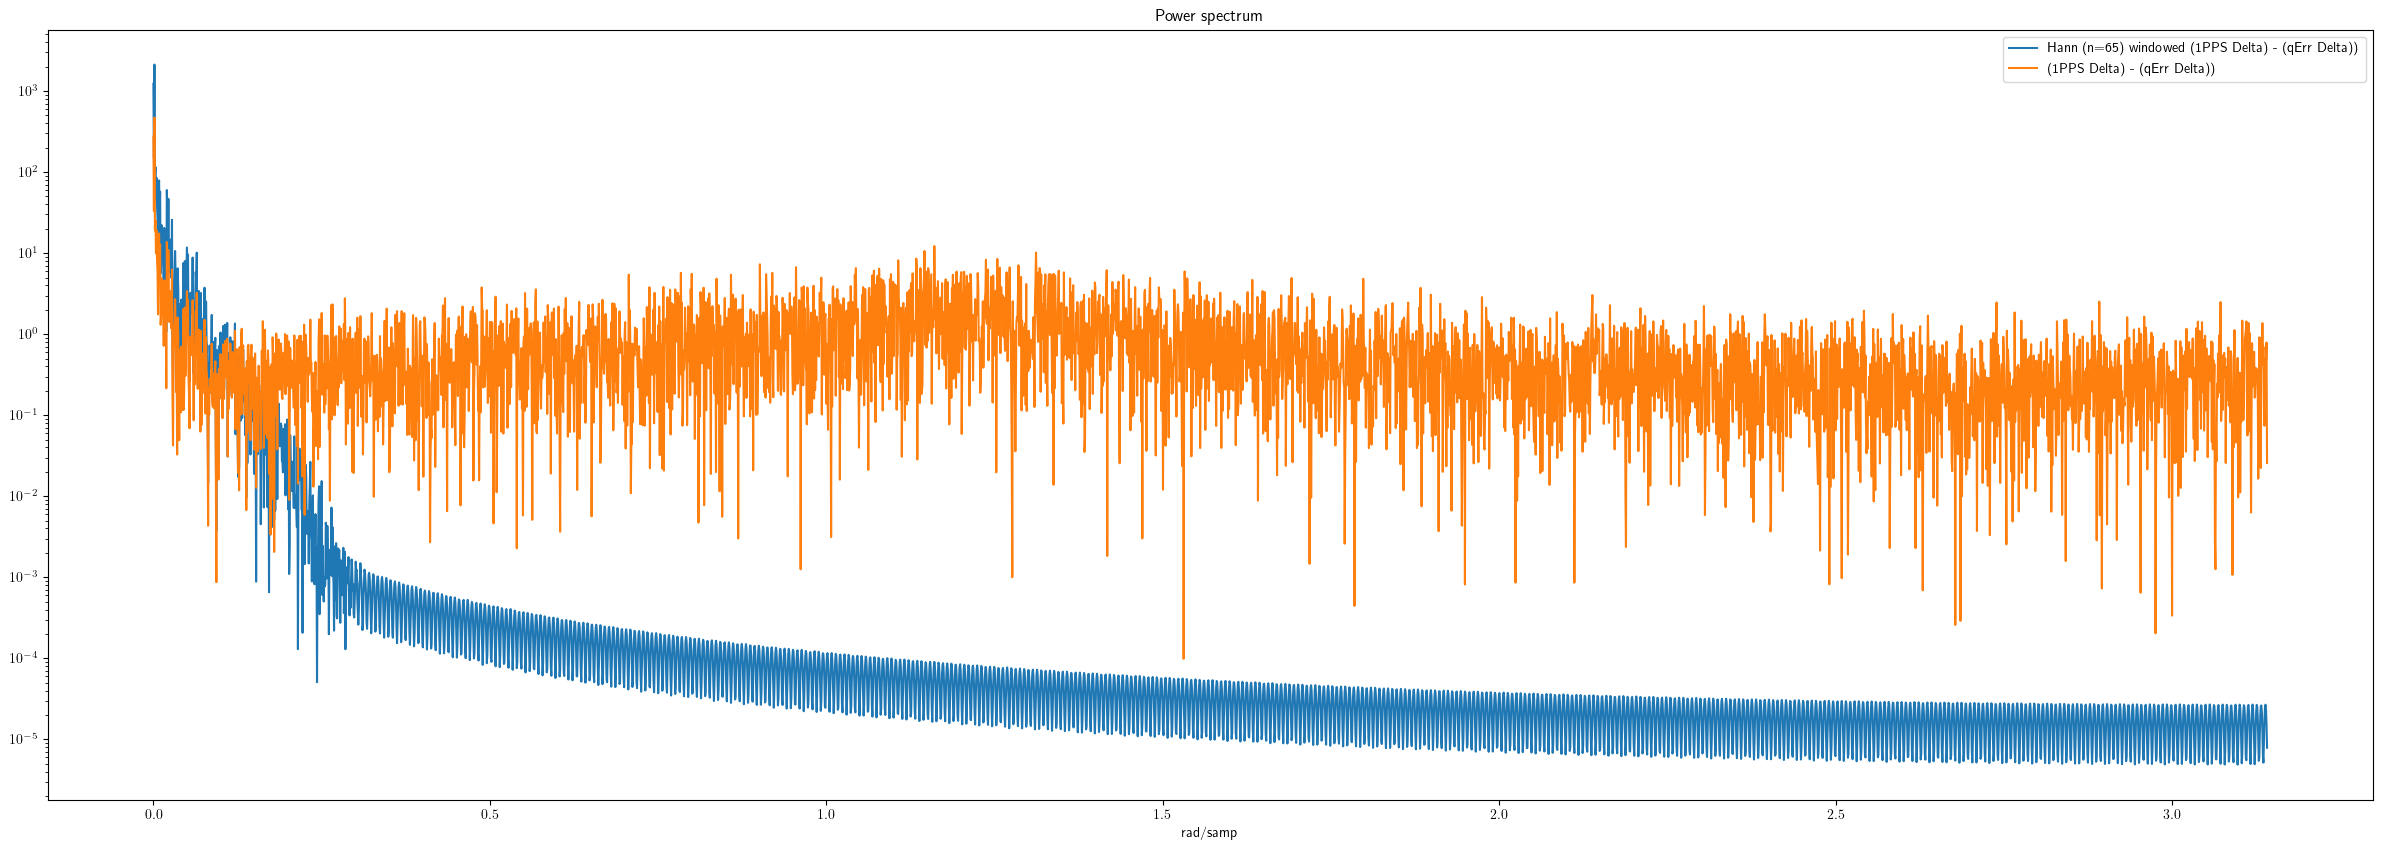

In [148]:
# Align data
aq0, aqerr0, aq1, aqerr1 = align_data(q0, qerr0, q1, qerr1)

for df in [aq0, aqerr0, aq1, aqerr1]:
    ...
    # print(len(df))
    # print(df['unix_timestamp'].iloc[0].round('ms'))
    # print(df['unix_timestamp'].iloc[-1].round('ms'))

# Compute differences

diffs = pd.DataFrame(columns=['quabo_wr_diffs', 'qerr_diffs', 'quabo_wr_diffs_without_qerrs'])

diffs['quabo_wr_diffs (ns)'] = ((aq0['wr_timestamp (s)'] - aq1['wr_timestamp (s)']) * 10**9).astype(np.float64)  # Do second -> nanosecond conversion with Decimal to elimiate floating-point errors
diffs['qerr_diffs (ns)'] = (aqerr1['qErr (ns)'] - aqerr0['qErr (ns)'])
diffs['quabo_wr_diffs_without_qerrs (ns)'] = diffs['quabo_wr_diffs (ns)'] - diffs['qerr_diffs (ns)']

n = 2**6 + 1
b = 10
window = scipy.signal.windows.kaiser(n, b, sym=True)
window /= n
diffs['windowed_quabo_wr_diffs_without_qerrs (ns)'] = scipy.signal.fftconvolve(diffs['quabo_wr_diffs (ns)'] - diffs['qerr_diffs (ns)'], window, mode='same')


y1 = diffs['windowed_quabo_wr_diffs_without_qerrs (ns)']
y2 = diffs['quabo_wr_diffs_without_qerrs (ns)']

next_largest_power_of_2 = int(2**(np.ceil(np.log2(len(y1)))))

y1 = np.pad(y1, (0, next_largest_power_of_2 - len(y1)))
y2 = np.pad(y2, (0, next_largest_power_of_2 - len(y2)))

N = min(len(y1), 2**14)       # FFT size
X1 = np.fft.fft(y1, N)
X2 = np.fft.fft(y2, N)
X3 = np.fft.fft(window, N)

X_abs1 = X1 * np.conj(X1)
X_abs1 /= np.mean(X_abs1)
X_abs2 = X2 * np.conj(X2)
X_abs2 /= np.mean(X_abs2)
# X_abs3 = X3 * np.conj(X3)

# Plotting:
fig = plt.figure(figsize=(30, 10))
freqs = np.arange(0, N / 2) / N * (2*np.pi)

plt.semilogy(freqs, (X_abs1.real)[0:N//2], label=f'Hann (n={n}) windowed (1PPS Delta) - (qErr Delta))')
plt.semilogy(freqs, (X_abs2.real)[0:N//2], label=f'(1PPS Delta) - (qErr Delta))')
# plt.semilogy(freqs, (X_abs3.real)[0:N//2], label=f'window')

plt.xlabel('rad/samp')
plt.title('Power spectrum')

plt.legend()
# print()
print(diffs.describe())

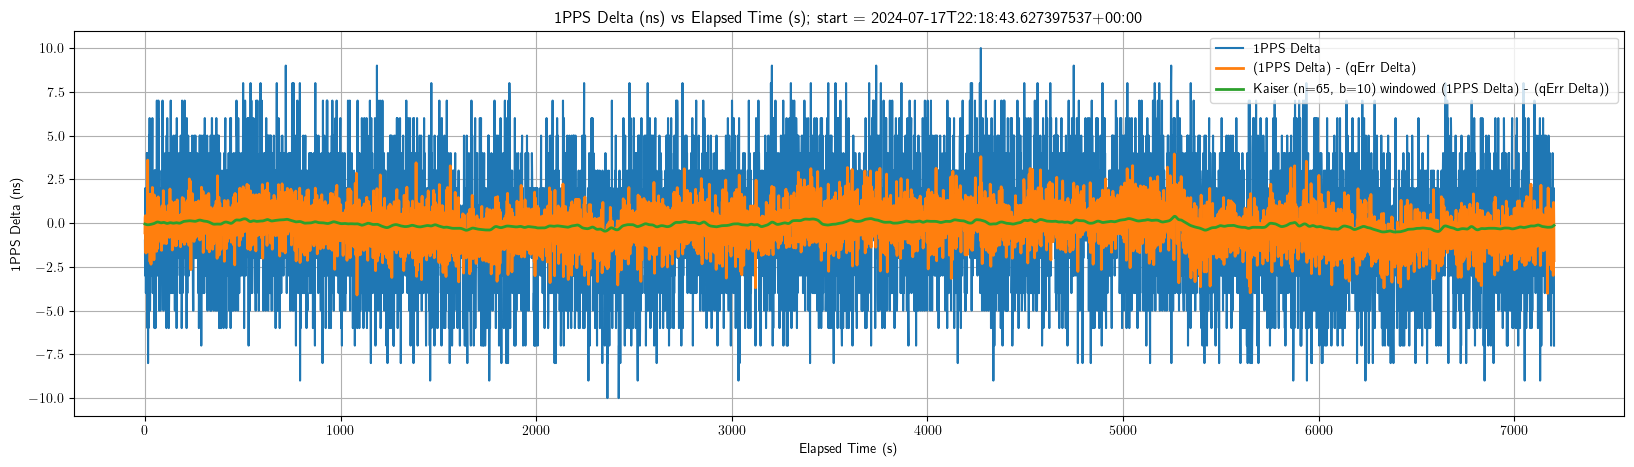

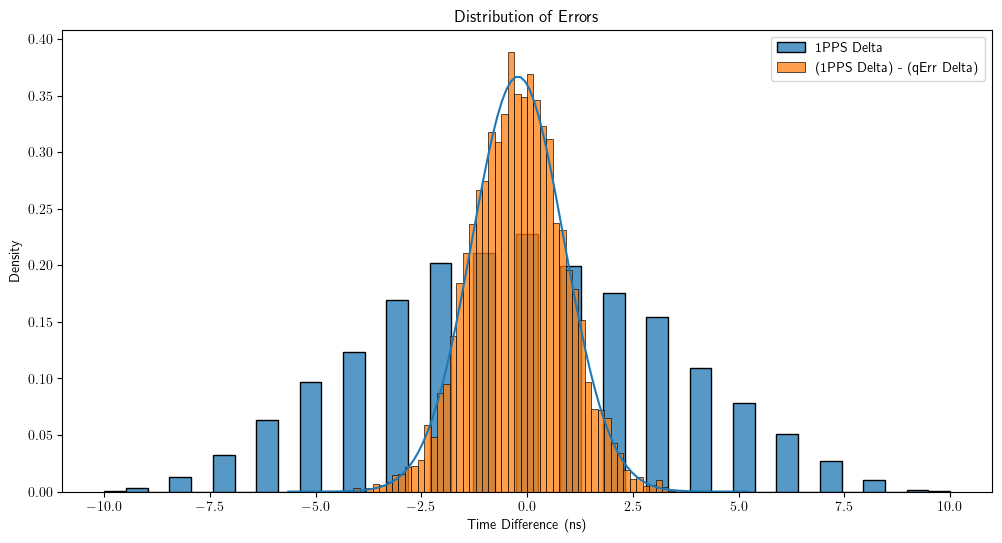

In [193]:
# Create plot

start_timestamp = aq0['unix_timestamp'][0].isoformat()

total_time = len(aq0)
time_per_window = total_time
nsubplots = total_time // time_per_window

plot_qerr = False

xtick_spacing = 20
ax_height = 5
ax_width = 20

f, axs = plt.subplots(nsubplots, 1, figsize=(ax_width, ax_height * nsubplots))

for i in range(nsubplots):
    t_low = time_per_window * i
    t_high = time_per_window * (i + 1)
    diffs_in_window = diffs[t_low: t_high]
    
    if nsubplots > 1:
        ax = axs[i]
    else:
        ax = axs
    
    sns.lineplot(
        diffs_in_window['quabo_wr_diffs (ns)'],
        label='1PPS Delta', 
        ax=ax
    )
    sns.lineplot(
        diffs_in_window['quabo_wr_diffs_without_qerrs (ns)'],
        label='(1PPS Delta) - (qErr Delta)',
        ax=ax,
        linewidth = 2
    )

    sns.lineplot(
        diffs_in_window['windowed_quabo_wr_diffs_without_qerrs (ns)'],
        label=f'Kaiser (n={n}, b={b}) windowed (1PPS Delta) - (qErr Delta))',
        ax=ax,
        linewidth = 2
    )
    
    if plot_qerr:
        sns.lineplot(
            diffs_in_window['qerr_diffs (ns)'],
            label='qErr Delta',
            ax=ax
        )

    # Style axis
    
    ax.set_xlabel('Elapsed Time (s)')
    if xtick_spacing and time_per_window != total_time:
        ax.set_xticks(np.arange(t_low, t_high + xtick_spacing, xtick_spacing))
    # ax.set_xlim([t_low, t_high])
    
    ax.set_ylabel('1PPS Delta (ns)')
    # ax.set_yticks(np.arange(-7.5, 27.5, 2.5))
    
    ax.grid(True)
    
    if i == 0:
        ax.set_title(f'1PPS Delta (ns) vs Elapsed Time (s); start = {start_timestamp}')
    # else:
    #     ax.get_legend().remove();


plt.figure(figsize=(12,6))
# plt.grid(True)
sns.histplot(diffs['quabo_wr_diffs (ns)'], stat='density', label='1PPS Delta', common_bins=False);
sns.histplot(diffs['quabo_wr_diffs_without_qerrs (ns)'], stat='density', label='(1PPS Delta) - (qErr Delta)');


mu, sigma = scipy.stats.norm.fit(diffs['quabo_wr_diffs_without_qerrs (ns)'])
x = np.linspace(mu - 5*sigma, mu + 5*sigma, 100)
g = scipy.stats.norm.pdf(x, mu, sigma)
plt.plot(x, g)

# sns.histplot(scipy.
# sns.histplot(diffs['windowed_quabo_wr_diffs_without_qerrs (ns)'], stat='density', label=f'Hann (n={n}) windowed (1PPS Delta) - (qErr Delta))', bins=10);


plt.legend()
plt.title('Distribution of Errors')
plt.xlabel('Time Difference (ns)');

# print(diffs.describe())

In [248]:
for i in range(10000):
    g = np.random.randn(1000)
    
    p = scipy.stats.normaltest(g).pvalue
    if p < 1e-5:
        print(p)

6.539860527056548e-06


In [249]:
scipy.stats.normaltest(diffs['quabo_wr_diffs_without_qerrs (ns)'])

NormaltestResult(statistic=2.904079431977544, pvalue=0.23409231895304475)

In [188]:
scipy.stats.normaltest(diffs['qerr_diffs (ns)'])

NormaltestResult(statistic=213.2503280375086, pvalue=4.934914522002051e-47)

In [189]:
scipy.stats.normaltest(diffs['quabo_wr_diffs (ns)'])

NormaltestResult(statistic=102.06048825107808, pvalue=6.884090421759762e-23)

In [190]:
scipy.stats.normaltest(aqerr0['qErr (ns)'])

NormaltestResult(statistic=5422.507327387108, pvalue=0.0)

In [191]:
scipy.stats.normaltest(aqerr1['qErr (ns)'])

NormaltestResult(statistic=6556.968903974648, pvalue=0.0)

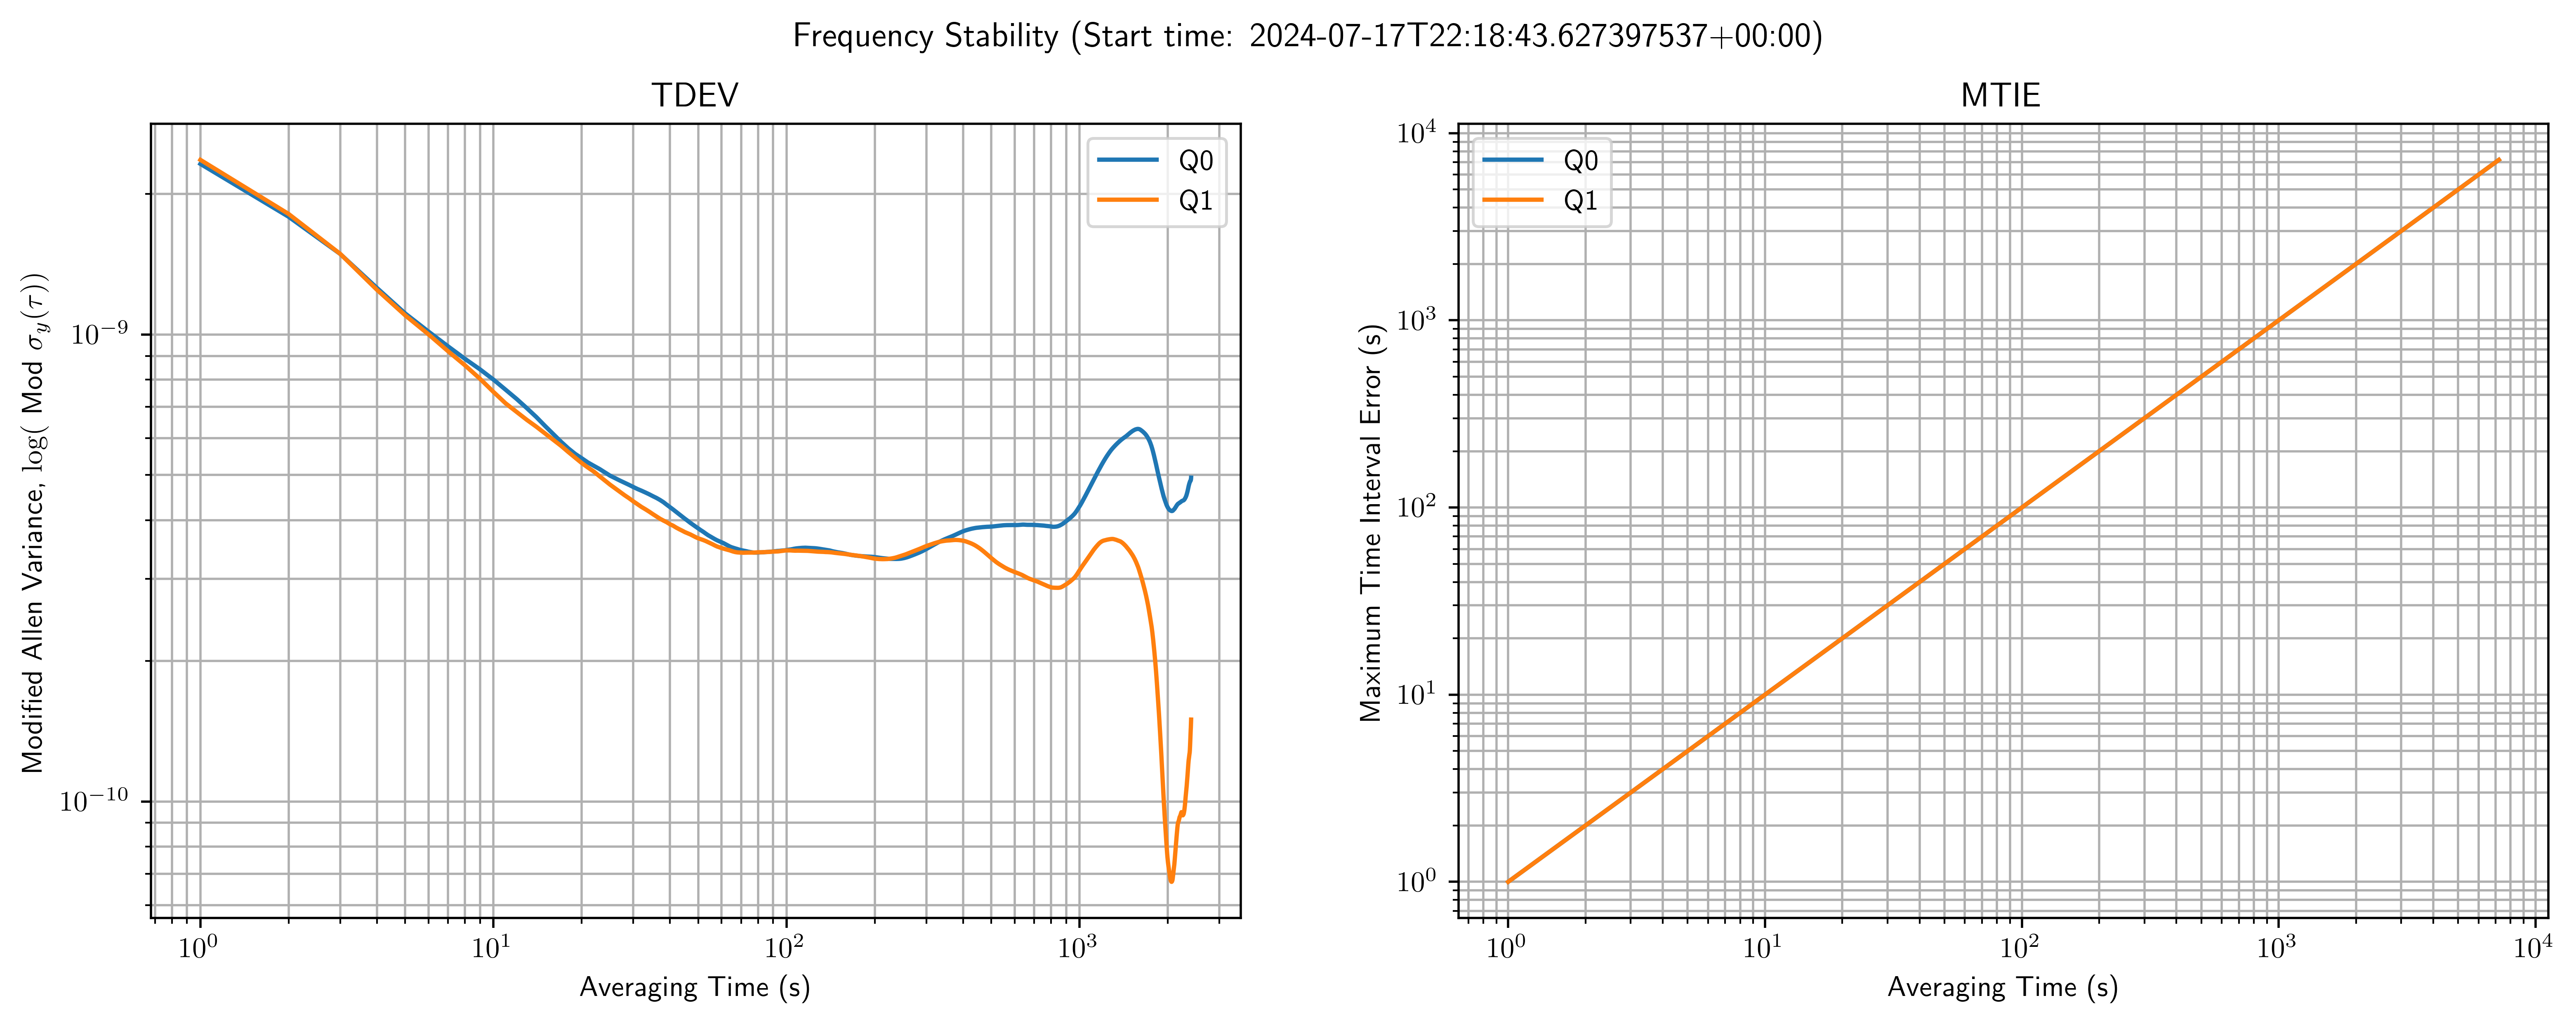

In [150]:
# Code for testing TIE
def get_clkerr(quabo_data):
    ideal_clock_period = 1
    clkerr = pd.DataFrame(columns = ['ideal clk time', 'actual clk time', 'actual clk period', 'period change', 'time interval error'])
    clkerr['ideal clk time'] = np.arange(len(quabo_data))
    clkerr['actual clk time'] = (quabo_data['wr_timestamp (s)'] - quabo_data['wr_timestamp (s)'].min()).astype(np.float64)
    clkerr['time interval error (s)'] = clkerr['actual clk time'] - clkerr['ideal clk time']
    clkerr['actual clk period (s)'] = clkerr['actual clk time'].diff()
    clkerr['period change'] = clkerr['actual clk period'].diff()
    return clkerr

clkerr0 = get_clkerr(aq0)
clkerr1 = get_clkerr(aq1)
# print(clkerr0['actual clk period (s)'].describe(), '\n' * 2, clkerr1['actual clk period (s)'].describe())

tdev_taus0, tdev0, tdev_error0, tdev_ns0 = allantools.tdev(clkerr0['actual clk time'], taus = "all")
mtie_taus0, mtie0, mtie_error0, mtie_ns0 = allantools.mtie(clkerr0['actual clk time'], taus = "all")

tdev_taus1, tdev1, tdev_error1, tdev_ns1 = allantools.tdev(clkerr1['actual clk time'], taus = "all")
mtie_taus1, mtie1, mtie_error1, mtie_ns1 = allantools.mtie(clkerr1['actual clk time'], taus = "all")

f, axs = plt.subplots(1, 2, figsize=(15, 5), dpi=500)
f.suptitle(f'Frequency Stability (Start time: {start_timestamp})')

sns.lineplot(x=tdev_taus0, y=tdev0, ax=axs[0], label='Q0')
sns.lineplot(x=tdev_taus1, y=tdev1, ax=axs[0], label='Q1')

sns.lineplot(x=mtie_taus0, y=mtie0, ax=axs[1], label='Q0')
sns.lineplot(x=mtie_taus1, y=mtie1, ax=axs[1], label='Q1')

plt.rcParams['text.usetex'] = True
for ax in axs:
    ax.set_xlabel('Averaging Time (s)')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid(True, which='both')

axs[0].set_title('TDEV')
axs[0].set_ylabel(f'Modified Allen Variance, $\\log($ Mod $\\sigma_y(\\tau))$')

axs[1].set_title('MTIE')
axs[1].set_ylabel('Maximum Time Interval Error (s)');

In [ ]:
# break into segments, window, and compute the FFT.

N = 4096*2**5       # FFT size

y = diffs_in_window['windowed_quabo_wr_diffs_without_qerrs (ns)']
next_largest_power_of_2 = int(2**(np.ceil(np.log2(len(y)))))
y = np.pad(y, (0, next_largest_power_of_2 - len(y)))

X = np.array([np.fft.fft(segment * np.kaiser(2**10, 6), N) for segment in np.split(y, 2**3)])

# Compute means
Pspect = np.mean(np.abs(X), axis=0)
Pspect_cplx = np.abs(np.mean(X, axis=0))

# Plotting:
fig = plt.figure(figsize=(16, 4))
plt.semilogy(np.arange(0, N / 2) / N * (2*np.pi), Pspect[0:N//2])
plt.xlabel('rad/samp')
plt.title('Average power spectrum')
fig = plt.figure(figsize=(16,2))

plt.semilogy(np.arange(0, N / 2) / N * (2*np.pi),Pspect_cplx[0:N//2])
plt.xlabel('rad/samp')
plt.title('Complex average of the spectrum');